# Question 2

In this question we will:
- Implement the vector median filter for colour images.
- Apply the vector median filter to a small dataset and establish a baseline performance meteric.
- Try to design a denoising pipeline that outperforms using only the vector median filter.   

# Step 1: Implement the vector median filter for colour images.

## Instructions

- Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation suggestions can be found in Section 2 of the asignment PDF.  
- The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.
- Your function should accept images of dtype `uint8` or `float64` (other types may be rejected if you wish).    It is easiest if you work with the image as data type `float64`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float64`, construct the output image also as type `float64` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [78]:
import skimage.io as skio
import skimage.color as skcolor
import skimage.util as skutil
import skimage.restoration as skrest
import skimage.filters as skfilt
import skimage.metrics as skmetrics
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import median_filter

In [6]:
files = pd.read_csv("images/images.csv", header=None)
png_list = files[0].tolist()

In [49]:
def vector_median(I: np.ndarray, radius: int) -> np.ndarray:

    #Type checking/verification
    if not isinstance(I, np.ndarray):
        raise TypeError("I must be a numpy array")
    
    orig_dtype = I.dtype
    if orig_dtype not in [np.uint8, np.float64]:
        raise TypeError('Unsupported image type: {}'.format(orig_dtype))
    if not (isinstance(radius,int) and radius >= 0):
        raise ValueError("radius must be a none-negative integer ")
    if I.ndim != 3:
        raise ValueError("Input image must be colour (3D)")
    
    # Convert to float64 for working
    img = skutil.img_as_float64(I) if orig_dtype == np.uint8 else I.copy()
    
    # Storing original image shape
    H, W, _ = img.shape

    # k is window diameter, makes looping easier later
    k = 2*radius + 1

    # Pad image so we can filter the edges of the image with same radius
    padded = np.pad(img, ((radius,radius), (radius,radius), (0,0)), mode='reflect')

    output = np.empty_like(img)

    for i in range(H):
        # Grab the rows we care about for this pixel
        row_section = padded[i:i+k]
        for j in range(W):
            # Grab the columns we care about for this pixel
            region = row_section[:, j:j+k, :]
            # Order the vectors with top left being "0" and counting left to right, top to bottom, then lay them out in order
            V = region.reshape(-1,3)
            n = V.shape[0]

            # As described in assignment notes
            Y = np.tile(V[:,:,None], (1,1,n))
            X = np.tile(V.T[None,:,:], (n,1,1))

            D = np.sum(np.abs(X-Y), axis=(0,1))

            kmin = np.argmin(D)
            output[i,j,:] = V[kmin, :]

    if orig_dtype == np.uint8:
        output = skutil.img_as_ubyte(output)

    return output

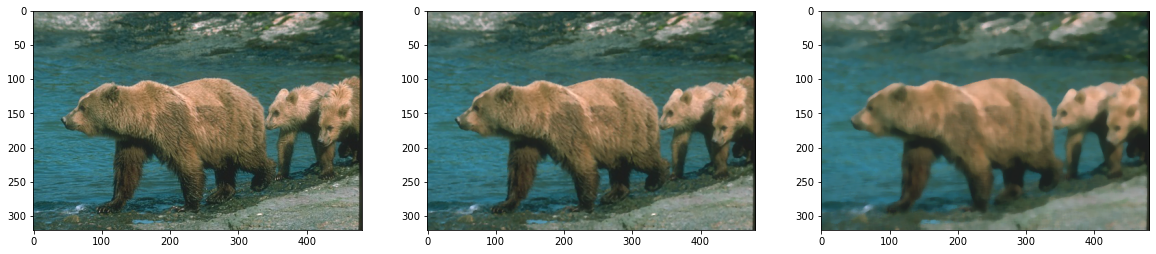

In [50]:
files = pd.read_csv("images/images.csv", header=None)
png_list = files[0].tolist()

img = skio.imread(f"images/images/noiseless/{png_list[0]}")

fig, ax = plt.subplots(1,3, figsize=(20,60))
ax[0].imshow(img)
ax[1].imshow(vector_median(img,1))
ax[2].imshow(vector_median(img,3))

# Step 2a: Establish a Baseline

## Instructions

- Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list.  
    - Use the same method to read the images files as in question 1, but read them from the `images/noisy` directory and the `images/noiseless` directory as needed.
- Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.   
    - As with question 1, to save time we recommend you develop and debug your programs using only the first three to five images in file_list, and run it on the complete list when you're done. 
- The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skmetrics.peak_signal_noise_ratio()` and `skmetrics.structural_similarity()`.  You'll need the `channel_axis=2` argument for `structural_similarity()`.  This indicates to the function that the it is the 3rd dimension of the 3D arrays that index the R, G and B channels.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._



Processed 200 images
Example (first file): 100075.png
PSNR noisy (first 5): [19.336508510572344, 20.935314536670294, 20.105296679694238, 19.650410393962005, 19.464087467923473]
SSIM noisy (first 5): [0.4134973802463569, 0.3360906085668299, 0.6716168918439926, 0.3757365955973179, 0.3623775304814291]
PSNR filtered (first 5): [26.42819956833862, 30.862879282716214, 23.2725104834199, 28.11927886890219, 26.115092511682732]
SSIM filtered (first 5): [0.6259456032757391, 0.6866582258716526, 0.7171217415240024, 0.6856312585178678, 0.6007825149744916]


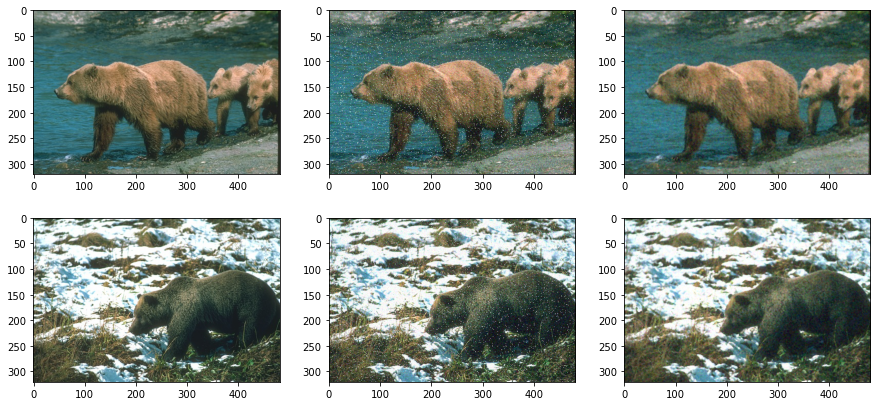

In [ ]:
noiseless_imgs = []
noisy_imgs = []
filtered_imgs = []


psnr_noisy_list = []
ssim_noisy_list = []
psnr_filtered_list = []
ssim_filtered_list = []

def find_data_range(img):
    if np.issubdtype(img.dtype, np.integer):
        return np.iinfo(img.dtype).max
    else:
        # floats are in range [0,1]
        return 1.0


for filename in png_list:   # you can restrict this to, for example,  file_list[0:3], for testing
    noisy_img = skio.imread(f"images/images/noisy/{filename}")
    noiseless_img = skio.imread(f"images/images/noiseless/{filename}")

    if noiseless_img.shape != noisy_img.shape:
        print(f"Skipping {filename}: Shape mismatch, Noisy:{noisy_img.shape} vs. Noiseless: {noiseless_img.shape}")

    noiseless_imgs.append(noiseless_img)
    noisy_imgs.append(noisy_img)

    data_range = find_data_range(noiseless_img)

    psnr_noisy = skmetrics.peak_signal_noise_ratio(noiseless_img, noisy_img, data_range=data_range)
    ssim_noisy = skmetrics.structural_similarity(noiseless_img, noisy_img, channel_axis=2)

    psnr_noisy_list.append(psnr_noisy)
    ssim_noisy_list.append(ssim_noisy)

    filtered = vector_median(noisy_img, 1)
    filtered_imgs.append(filtered)

    psnr_filt = skmetrics.peak_signal_noise_ratio(noiseless_img, filtered, data_range=data_range)
    ssim_filt = skmetrics.structural_similarity(noiseless_img, filtered, channel_axis=2)

    psnr_filtered_list.append(psnr_filt)
    ssim_filtered_list.append(ssim_filt)

print("Processed", len(psnr_noisy_list), "images")
print("Example (first file):", png_list[0] if len(png_list) else "none")
print("PSNR noisy (first 5):", psnr_noisy_list[:5])
print("SSIM noisy (first 5):", ssim_noisy_list[:5])
print("PSNR filtered (first 5):", psnr_filtered_list[:5])
print("SSIM filtered (first 5):", ssim_filtered_list[:5])

fig, ax = plt.subplots(2,3, figsize = (15,7))
ax[0,0].imshow(noiseless_imgs[0])
ax[0,1].imshow(noisy_imgs[0])
ax[0,2].imshow(filtered_imgs[0])
ax[1,0].imshow(noiseless_imgs[2])
ax[1,1].imshow(noisy_imgs[2])
ax[1,2].imshow(filtered_imgs[2])
    

# Step 2b: Compute average baseline metrics.

## Instructions

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

[20.272167535817452, 25.96120161220467]
[0.4736273430389176, 0.6475631664752595]


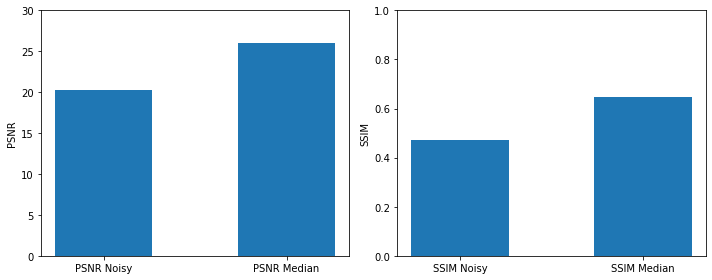

In [76]:
psnr_noisy_ave = np.average(psnr_noisy_list)
psnr_filter_ave = np.average(psnr_filtered_list)
ssim_noisy_ave = np.average(ssim_noisy_list)
ssim_filtered_ave = np.average(ssim_filtered_list)

psnr_aves = [psnr_noisy_ave, psnr_filter_ave]
ssim_aves = [ssim_noisy_ave, ssim_filtered_ave]
print(psnr_aves)
print(ssim_aves)

psnr_names = ["PSNR Noisy", "PSNR Median"]
ssim_names = ["SSIM Noisy", "SSIM Median"]

x = [1,2.5]
width = 0.8  # the width of the bars
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(x, psnr_aves, width)
axs[0].set_xticks(x)
axs[0].set_xticklabels(psnr_names)
axs[0].set_ylabel('PSNR')
axs[0].set_ylim(0,30)
axs[1].bar(x, ssim_aves, width)
axs[1].set_xticks(x)
axs[1].set_xticklabels(ssim_names)
axs[1].set_ylabel('SSIM')
axs[1].set_ylim(0,1)

plt.tight_layout()
plt.show()

# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


In [144]:
'''
Reading the generator file:
impulse noise is 100% salt
replaced about 2% of pixels with salt
only applied the noise if the pixel being applied to was in the dark half of the colours when converted to gray
added gaussian noise to colour image with a variance between 0.001 and 0.005

Should be to find the salt pixels, remove them, then blur a bit to deal with the gaussian
'''

def denoise_mixed(img, med_size=3, t_imp=6.0, clip_impulse_hi=0.9):
    
    orig_dtype = img.dtype
    if orig_dtype == np.uint8:
        im = skutil.img_as_float64(img)
    else:
        im = img.copy()

    # Turn it gray to find impulse noise
    gray = skcolor.rgb2gray(im)

    # Local median into median absolute deviation filter, good at finding outliers (learned this is stats :) )
    med = median_filter(gray, size=med_size, mode='reflect')
    mad = median_filter(np.abs(gray - med), size=med_size, mode='reflect') + 1e-8

    # Make a mask that highlights the salt pixels
    z = (gray - med) / mad
    impulse_mask = (z > t_imp) & (gray > clip_impulse_hi)

    # Color median replacement only where flagged
    ch_meds = []
    for c in range(3):
        ch_meds.append(median_filter(im[..., c], size=med_size, mode='reflect'))
    med_rgb = np.stack(ch_meds, axis=-1)
    stage1 = np.where(impulse_mask[..., None], med_rgb, im)

    # Estimate Gaussian sigma and wavelet denoise (good for gaussian according to "https://scikit-image.org/docs/0.25.x/auto_examples/filters/plot_denoise_wavelet.html")
    sigma_est = skrest.estimate_sigma(stage1, channel_axis=-1, average_sigmas=True)
    stage2 = skrest.denoise_wavelet(
        stage1,
        sigma = sigma_est,
        channel_axis=-1,
        convert2ycbcr=True,
        method='BayesShrink',
        mode='soft',
        rescale_sigma=True
    )

    out = np.clip(stage2, 0.0, 1.0)
    if orig_dtype == np.uint8:
        out = (out * 255.0 + 0.5).astype(np.uint8)
    return out

In [167]:
my_filtered_images = []
my_filtered_psnrs = []
my_filtered_ssims = []

for clean, noisy in zip(noiseless_imgs, noisy_imgs):
    my_filtered = denoise_mixed(noisy, med_size=7, t_imp=5, clip_impulse_hi= 0.95)
    my_filtered_images.append(my_filtered)

    data_range = find_data_range(clean)

    psnr = skmetrics.peak_signal_noise_ratio(clean, my_filtered, data_range=data_range)
    ssim = skmetrics.structural_similarity(clean, my_filtered, channel_axis=2)

    my_filtered_psnrs.append(psnr)
    my_filtered_ssims.append(ssim)

[20.272167535817452, 25.96120161220467, 29.995125365227914]
[0.4736273430389176, 0.6475631664752595, 0.8334849077835568]


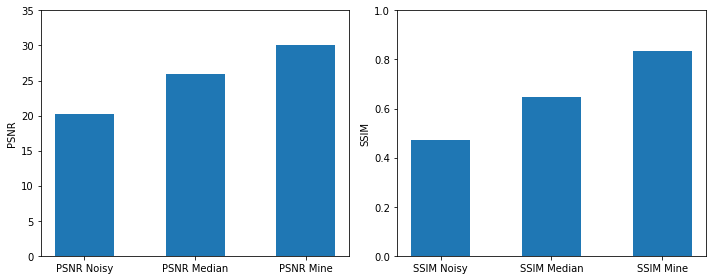

In [170]:
my_psnr_ave = np.average(my_filtered_psnrs)
my_ssim_ave = np.average(my_filtered_ssims)


psnr_aves = [psnr_noisy_ave, psnr_filter_ave, my_psnr_ave]
ssim_aves = [ssim_noisy_ave, ssim_filtered_ave, my_ssim_ave]
print(psnr_aves)
print(ssim_aves)

psnr_names = ["PSNR Noisy", "PSNR Median", "PSNR Mine"]
ssim_names = ["SSIM Noisy", "SSIM Median", "SSIM Mine"]

x = [1,2.5, 4]
width = 0.8  # the width of the bars
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(x, psnr_aves, width)
axs[0].set_xticks(x)
axs[0].set_xticklabels(psnr_names)
axs[0].set_ylabel('PSNR')
axs[0].set_ylim(0,35)
axs[1].bar(x, ssim_aves, width)
axs[1].set_xticks(x)
axs[1].set_xticklabels(ssim_names)
axs[1].set_ylabel('SSIM')
axs[1].set_ylim(0,1)

plt.tight_layout()
plt.show()